In [85]:
import sys, os, time
#%load_ext autoreload
#%autoreload 2
import torch
import torch.nn.functional as F
from torch.autograd import grad
import torch.distributions as distrib
import torch.nn as nn
import torch.utils.data as td
from torch.utils.data import Dataset, DataLoader, TensorDataset
import gym
import numpy as np
#%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt
#from envs import Discrete_Pos_Trap, Gym_Env, Print_Env
from torch.distributions.utils import lazy_property
import foundation as fd
from foundation import nets
from foundation.util import replicate, Cloner
import torch.multiprocessing as mp
import time

In [92]:
D, B, C = 128, 16, 10

In [106]:
def gen(N, w=1):
    x = torch.sin(2*w*(torch.arange(N).unsqueeze(0).expand(N,N)+torch.arange(N).unsqueeze(1)).float()/N*np.pi)
    return x

xs = torch.cat([gen(D,c) for c in range(1,C+1)],0)
ys = torch.cat([torch.ones(D)*c for c in range(C)],0).long()

dataset = TensorDataset(xs, ys)
loader = DataLoader(dataset, batch_size=B, shuffle=True)
len(dataset), len(loader)

(1280, 80)

In [107]:
model = nets.make_MLP(input_dim=D, output_dim=C, hidden_dims=[64, 32], nonlin='elu')
optim = nets.get_optimizer(optim_type='adam', parameters=model.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
total_epochs = 0
print(model)

Sequential(
  (0): Linear(in_features=128, out_features=64, bias=True)
  (1): ELU(alpha=1.0, inplace)
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ELU(alpha=1.0, inplace)
  (4): Linear(in_features=32, out_features=10, bias=True)
)


In [108]:
print_freq = max(len(loader)//100, 1)
for _ in range(10):
    for i, (x,y) in enumerate(loader):

        pred = model(x)
        
        loss = criterion(pred, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if i % print_freq == 0:
            print('Epoch {} iteration {}/{}: loss {}'.format(total_epochs+1, i+1, len(loader), loss.item()))

    total_epochs += 1

Epoch 1 iteration 1/80: loss 2.2780117988586426
Epoch 1 iteration 2/80: loss 2.2867558002471924
Epoch 1 iteration 3/80: loss 2.2779459953308105
Epoch 1 iteration 4/80: loss 2.258613109588623
Epoch 1 iteration 5/80: loss 2.291640281677246
Epoch 1 iteration 6/80: loss 2.3204331398010254
Epoch 1 iteration 7/80: loss 2.3393006324768066
Epoch 1 iteration 8/80: loss 2.280150890350342
Epoch 1 iteration 9/80: loss 2.3294172286987305
Epoch 1 iteration 10/80: loss 2.197899580001831
Epoch 1 iteration 11/80: loss 2.2181217670440674
Epoch 1 iteration 12/80: loss 2.3398983478546143
Epoch 1 iteration 13/80: loss 2.2353081703186035
Epoch 1 iteration 14/80: loss 2.3041932582855225
Epoch 1 iteration 15/80: loss 2.3603641986846924
Epoch 1 iteration 16/80: loss 2.3132033348083496
Epoch 1 iteration 17/80: loss 2.4071357250213623
Epoch 1 iteration 18/80: loss 2.2326273918151855
Epoch 1 iteration 19/80: loss 2.1468887329101562
Epoch 1 iteration 20/80: loss 2.4264132976531982
Epoch 1 iteration 21/80: loss 2.3

Epoch 3 iteration 43/80: loss 0.48376965522766113
Epoch 3 iteration 44/80: loss 0.6463886499404907
Epoch 3 iteration 45/80: loss 0.5002687573432922
Epoch 3 iteration 46/80: loss 0.43513500690460205
Epoch 3 iteration 47/80: loss 0.4710639715194702
Epoch 3 iteration 48/80: loss 0.4244162440299988
Epoch 3 iteration 49/80: loss 0.6184961795806885
Epoch 3 iteration 50/80: loss 0.7258809208869934
Epoch 3 iteration 51/80: loss 0.5338650941848755
Epoch 3 iteration 52/80: loss 0.46936285495758057
Epoch 3 iteration 53/80: loss 0.6068406105041504
Epoch 3 iteration 54/80: loss 0.579372763633728
Epoch 3 iteration 55/80: loss 0.44789209961891174
Epoch 3 iteration 56/80: loss 0.35565078258514404
Epoch 3 iteration 57/80: loss 0.41945335268974304
Epoch 3 iteration 58/80: loss 0.5132163763046265
Epoch 3 iteration 59/80: loss 0.4834505319595337
Epoch 3 iteration 60/80: loss 0.44100984930992126
Epoch 3 iteration 61/80: loss 0.47723567485809326
Epoch 3 iteration 62/80: loss 0.4043658971786499
Epoch 3 itera

Epoch 5 iteration 77/80: loss 0.026533275842666626
Epoch 5 iteration 78/80: loss 0.024577319622039795
Epoch 5 iteration 79/80: loss 0.025142669677734375
Epoch 5 iteration 80/80: loss 0.025624781847000122
Epoch 6 iteration 1/80: loss 0.022689133882522583
Epoch 6 iteration 2/80: loss 0.02561117708683014
Epoch 6 iteration 3/80: loss 0.03230425715446472
Epoch 6 iteration 4/80: loss 0.026601403951644897
Epoch 6 iteration 5/80: loss 0.020017683506011963
Epoch 6 iteration 6/80: loss 0.02350980043411255
Epoch 6 iteration 7/80: loss 0.022836238145828247
Epoch 6 iteration 8/80: loss 0.027106821537017822
Epoch 6 iteration 9/80: loss 0.02366778254508972
Epoch 6 iteration 10/80: loss 0.02525883913040161
Epoch 6 iteration 11/80: loss 0.025427937507629395
Epoch 6 iteration 12/80: loss 0.02029779553413391
Epoch 6 iteration 13/80: loss 0.02861964702606201
Epoch 6 iteration 14/80: loss 0.02303224802017212
Epoch 6 iteration 15/80: loss 0.021762847900390625
Epoch 6 iteration 16/80: loss 0.0205824375152587

Epoch 8 iteration 72/80: loss 0.01230531930923462
Epoch 8 iteration 73/80: loss 0.007930874824523926
Epoch 8 iteration 74/80: loss 0.009025394916534424
Epoch 8 iteration 75/80: loss 0.009852230548858643
Epoch 8 iteration 76/80: loss 0.010515272617340088
Epoch 8 iteration 77/80: loss 0.012086629867553711
Epoch 8 iteration 78/80: loss 0.008543550968170166
Epoch 8 iteration 79/80: loss 0.010553091764450073
Epoch 8 iteration 80/80: loss 0.009401261806488037
Epoch 9 iteration 1/80: loss 0.00864100456237793
Epoch 9 iteration 2/80: loss 0.009216070175170898
Epoch 9 iteration 3/80: loss 0.00959789752960205
Epoch 9 iteration 4/80: loss 0.008248358964920044
Epoch 9 iteration 5/80: loss 0.009884893894195557
Epoch 9 iteration 6/80: loss 0.009910613298416138
Epoch 9 iteration 7/80: loss 0.008785545825958252
Epoch 9 iteration 8/80: loss 0.009947031736373901
Epoch 9 iteration 9/80: loss 0.01010403037071228
Epoch 9 iteration 10/80: loss 0.010088920593261719
Epoch 9 iteration 11/80: loss 0.009506583213

In [148]:
z = torch.zeros(D).unsqueeze(0)
z.requires_grad = True
m = torch.tensor([0]).long()
alpha = 1
zs = []

In [149]:
for i in range(10):
    z = z.detach()
    z.grad = None
    z.requires_grad = True
    pred = model(z)
    loss = criterion(pred, m)
    loss.backward()
    delta = z.grad
    z = z - alpha * delta
    zs.append(z.clone().detach())
    print('itr {}: loss={:.4f}, delta={:.4f}'.format(i, loss.item(), delta.norm().item()))

itr 0: loss=3.0082, delta=1.2312
itr 1: loss=1.6575, delta=0.9510
itr 2: loss=0.9394, delta=0.5851
itr 3: loss=0.6474, delta=0.4211
itr 4: loss=0.4911, delta=0.3245
itr 5: loss=0.3959, delta=0.2637
itr 6: loss=0.3320, delta=0.2220
itr 7: loss=0.2862, delta=0.1916
itr 8: loss=0.2518, delta=0.1686
itr 9: loss=0.2249, delta=0.1505


<IPython.core.display.Javascript object>


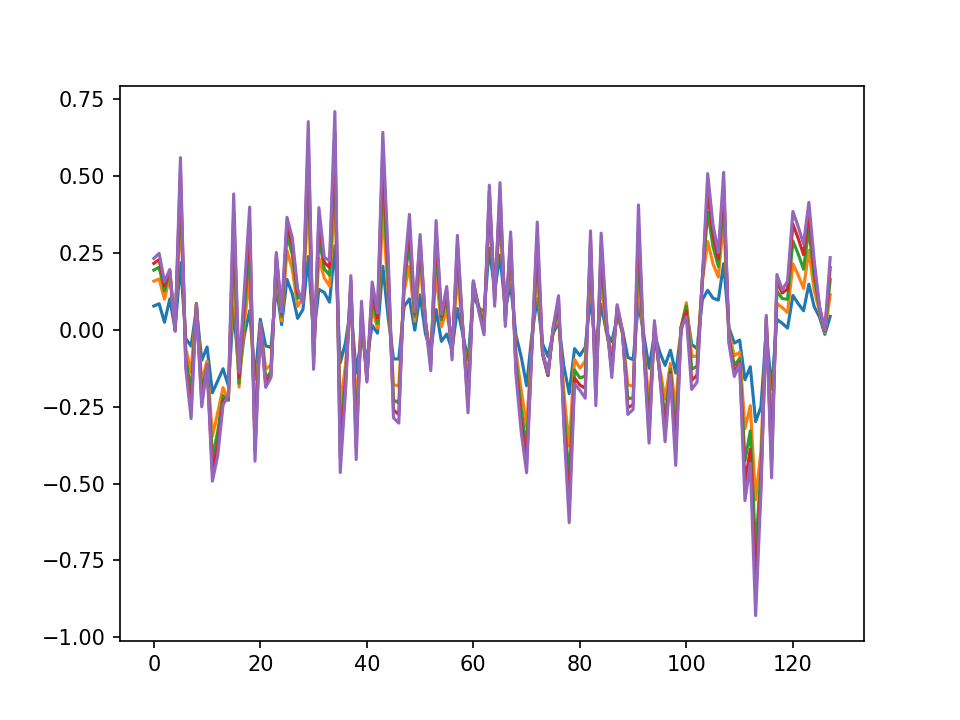

In [153]:
plt.figure()
for v in zs[:5]:
    plt.plot(v.squeeze().numpy())